In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Embedding, Input, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
import os
from google.colab import drive
from concurrent.futures import ThreadPoolExecutor, as_completed

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load Dataset
file_path = 'Final Fashion Dataset.csv'
data = pd.read_csv(file_path)

# Add image path to dataset
image_dir = '/content/drive/MyDrive/Images'
data['image_path'] = image_dir + '/' + data['filename']

# Display basic information to ensure it's loaded correctly
print(data[['id', 'filename', 'image_path']].head())

# Step 3: Load and Preprocess Images with Multithreading
image_size = (64, 64)  # Size for CNN model


Mounted at /content/drive
      id   filename                               image_path
0   8493   8493.jpg   /content/drive/MyDrive/Images/8493.jpg
1  30757  30757.jpg  /content/drive/MyDrive/Images/30757.jpg
2  14881  14881.jpg  /content/drive/MyDrive/Images/14881.jpg
3  48449  48449.jpg  /content/drive/MyDrive/Images/48449.jpg
4   4697   4697.jpg   /content/drive/MyDrive/Images/4697.jpg


In [ ]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np

# Define the image loading function
def load_and_preprocess_image(img_path):
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        return img_array
    else:
        print(f"Image {img_path} not found.")
        return None

# Function to load images with multithreading
def load_images_multithreaded(image_paths, max_workers=8):
    image_data = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit tasks to load images
        futures = {executor.submit(load_and_preprocess_image, path): path for path in image_paths}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                image_data.append(result)
    return np.array(image_data)

# Run multithreaded image loading
image_paths = data['image_path'].tolist()
item_images = load_images_multithreaded(image_paths, max_workers=8)  # Adjust max_workers based on your CPU capacity

print(f"Loaded {len(item_images)} images successfully.")


Image /content/drive/MyDrive/Images/4697.jpg not found.
Image /content/drive/MyDrive/Images/30757.jpg not found.
Image /content/drive/MyDrive/Images/17968.jpg not found.
Image /content/drive/MyDrive/Images/12868.jpg not found.
Image /content/drive/MyDrive/Images/14881.jpg not found.
Image /content/drive/MyDrive/Images/8493.jpg not found.
Image /content/drive/MyDrive/Images/52816.jpg not found.
Image /content/drive/MyDrive/Images/48449.jpg not found.
Image /content/drive/MyDrive/Images/39410.jpg not found.
Image /content/drive/MyDrive/Images/39401.jpg not found.
Image /content/drive/MyDrive/Images/39425.jpg not found.
Image /content/drive/MyDrive/Images/39403.jpg not found.


In [ ]:
# Step 4: Prepare Categorical Data
# Convert categorical features to integer labels
data['articleType_idx'] = data['articleType'].astype('category').cat.codes
data['subCategory_idx'] = data['subCategory'].astype('category').cat.codes
data['gender_idx'] = data['gender'].astype('category').cat.codes

# Prepare input data for the model
articleType_data = data['articleType_idx'].values
subCategory_data = data['subCategory_idx'].values
gender_data = data['gender_idx'].values

In [ ]:
import os

# Step 1: Identify missing images
missing_images = [path for path in data['image_path'] if not os.path.exists(path)]
print(f"Missing {len(missing_images)} images: {missing_images}")

# Step 2: Filter the data to only include rows where the image exists
valid_image_mask = data['image_path'].apply(os.path.exists)

# Step 3: Filter out the rows where the image does not exist
data_cleaned = data[valid_image_mask]

# Step 4: Recreate the arrays with the cleaned data
articleType_data = data_cleaned['articleType_idx'].values
subCategory_data = data_cleaned['subCategory_idx'].values
gender_data = data_cleaned['gender_idx'].values
image_paths = data_cleaned['image_path'].tolist()

# Step 5: Load the images for the cleaned data
item_images = load_images_multithreaded(image_paths, max_workers=8)

# Step 6: Check if the lengths are now consistent
print(len(item_images))  # Length of images
print(len(articleType_data))  # Length of articleType_data
print(len(subCategory_data))  # Length of subCategory_data
print(len(gender_data))  # Length of gender_data


Missing 5 images: ['/content/drive/MyDrive/Images/39410.jpg', '/content/drive/MyDrive/Images/39401.jpg', '/content/drive/MyDrive/Images/39425.jpg', '/content/drive/MyDrive/Images/39403.jpg', '/content/drive/MyDrive/Images/12347.jpg']
36479
36479
36479
36479


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

# Define the vocabulary sizes based on your dataset
num_articleTypes = data['articleType'].nunique()
num_subCategories = data['subCategory'].nunique()
num_genders = data['gender'].nunique()

# Input layers
image_input = Input(shape=(64, 64, 3), name='image_input')
articleType_input = Input(shape=(1,), name='articleType_input')
subCategory_input = Input(shape=(1,), name='subCategory_input')
gender_input = Input(shape=(1,), name='gender_input')

# CNN layers for image input
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)  # Flatten the CNN output
x = Dense(64, activation='relu')(x)  # Final image feature layer

# Embedding layers for categorical inputs
articleType_embedding = Embedding(input_dim=num_articleTypes, output_dim=10)(articleType_input)
subCategory_embedding = Embedding(input_dim=num_subCategories, output_dim=10)(subCategory_input)
gender_embedding = Embedding(input_dim=num_genders, output_dim=5)(gender_input)

# Flatten embeddings to match rank
articleType_embedding = Flatten()(articleType_embedding)
subCategory_embedding = Flatten()(subCategory_embedding)
gender_embedding = Flatten()(gender_embedding)

# Concatenate all feature layers
concatenated = Concatenate()([x, articleType_embedding, subCategory_embedding, gender_embedding])

# Additional dense layers for learning combined features
final_output = Dense(128, activation='relu')(concatenated)
final_output = Dense(64, activation='relu')(final_output)

# Model definition
model = Model(inputs=[image_input, articleType_input, subCategory_input, gender_input], outputs=final_output)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 62, 62, 32)     │            896 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 31, 31, 32)     │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 29, 29, 64)     │         18,496 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 14, 14, 64)     │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 6, 6, 128)      │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ articleType_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subCategory_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 4608)           │              0 │ max_pooling2d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 1, 10)          │            770 │ articleType_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 1, 10)          │            130 │ subCategory_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 1, 5)           │             25 │ gender_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │        294,976 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 10)             │              0 │ embedding_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 10)             │              0 │ embedding_10[0][0]     │
├──────────────────────

 Total params: 408,925 (1.56 MB)

 Trainable params: 408,925 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 6: Generate Item Feature Vectors (after training the model)
# Note: You need to train the model on your data, but for now, we simulate the prediction
# Simulating prediction for feature extraction (after training the model)
item_features = model.predict([item_images, articleType_data, subCategory_data, gender_data])

1140/1140 ━━━━━━━━━━━━━━━━━━━━ 67s 58ms/step


In [ ]:
## Step 7: Define Recommendation Logic using Cosine Similarity
def get_diverse_recommendations(input_item_vector, all_item_vectors, input_item_info, data, top_k=20):
    # Calculate similarity scores
    similarity_scores = cosine_similarity([input_item_vector], all_item_vectors)
    similar_item_indices = similarity_scores.argsort()[0][::-1]  # Sort in descending order

    recommended_items = []
    used_subcategories = set()
    used_articleTypes = set()

    for idx in similar_item_indices:
        if len(recommended_items) >= top_k:
            break

        item_info = data.iloc[idx]

        # Skip the input item itself
        if item_info['id'] == input_item_info['id']:
            continue

        # Skip items with the same articleType as the input item
        if item_info['articleType'] == input_item_info['articleType']:
            continue

        # Skip items with the same subCategory as the input item
        if item_info['subCategory'] == input_item_info['subCategory']:
            continue

        # Ensure unique subcategories in recommendations
        if item_info['subCategory'] in used_subcategories:
            continue

        # Check gender match with input item
        if item_info['gender'] != input_item_info['gender']:
            continue

        # Add to recommendations and track the subcategory and articleType
        recommended_items.append(item_info)
        used_subcategories.add(item_info['subCategory'])
        used_articleTypes.add(item_info['articleType'])

    # Return the final recommendations as a DataFrame
    return pd.DataFrame(recommended_items, columns=['id', 'articleType', 'subCategory', 'gender'])


In [ ]:
# Step 8: Get Diverse Recommendations for a Sample Item
input_item_index = 0  # Example input item index
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

# Get diverse recommendations
recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data, top_k=5)

# Step 9: Display Input Item and Recommended Items
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

Input Item Details:
id                   8493
articleType        Skirts
subCategory    Bottomwear
gender              Women
Name: 0, dtype: object

Recommended Outfit Items:
          id articleType subCategory gender
21226  50388     Watches     Watches  Women
22945  33735    Clutches        Bags  Women
18942  47593       Heels       Shoes  Women
9708   20323      Kurtas     Topwear  Women
30144  48915     Pendant   Jewellery  Women


In [ ]:
# Step 8: Get Diverse Recommendations for a Sample Item
input_item_index = 1  # Example input item index
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

# Get diverse recommendations
recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data, top_k=5)

# Step 9: Display Input Item and Recommended Items
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

Input Item Details:
id               30757
articleType     Kurtas
subCategory    Topwear
gender             Men
Name: 1, dtype: object

Recommended Outfit Items:
          id   articleType subCategory gender
7451   20683  Casual Shoes       Shoes    Men
35038  36770       Watches     Watches    Men
15687  47156       Wallets     Wallets    Men
23465  58331    Flip Flops  Flip Flops    Men
36246  21324    Sunglasses     Eyewear    Men


In [ ]:
# Step 8: Get Diverse Recommendations for a Sample Item
input_item_index = 2  # Example input item index
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

# Get diverse recommendations
recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data, top_k=5)

# Step 9: Display Input Item and Recommended Items
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

NameError: name 'item_features' is not defined

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load Dataset
dataset_path = 'Final Fashion Dataset.csv'
df = pd.read_csv(dataset_path)

Mounted at /content/drive


In [ ]:
image_folder ='/content/drive/MyDrive/Images'

In [ ]:
# Define complementary items with diverse categories
complementary_mapping = {
    'Skirts': ['Tshirts', 'Watches', 'Handbags', 'Heels'],
    'Tshirts': ['Jeans', 'Belts', 'Casual Shoes', 'Backpacks'],
    'Jeans': ['Shirts', 'Belts', 'Watches', 'Casual Shoes'],
    'Dresses': ['Heels', 'Clutches', 'Earrings', 'Watches'],
    'Shirts': ['Trousers', 'Formal Shoes', 'Belts', 'Watches'],
    'Kurtas': ['Leggings', 'Dupatta', 'Earrings', 'Sandals'],
    'Handbags': ['Tshirts', 'Jeans', 'Watches', 'Heels'],
    'Formal Shoes': ['Shirts', 'Trousers', 'Belts', 'Watches'],
    'Flip Flops': ['Shorts', 'Tshirts', 'Sunglasses'],
    'Heels': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Leggings': ['Tops', 'Kurtas', 'Dupatta', 'Sandals'],
    'Backpacks': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Earrings': ['Dresses', 'Clutches', 'Heels', 'Watches'],
    'Clutches': ['Heels', 'Dresses', 'Earrings', 'Necklace and Chains'],
    'Casual Shoes': ['Jeans', 'Tshirts', 'Belts', 'Backpacks'],
    'Dupatta': ['Kurtas', 'Leggings', 'Sandals', 'Earrings'],
    'Tops': ['Skirts', 'Watches', 'Handbags', 'Heels'],
    'Ring': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Flats': ['Shorts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suspenders': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Sports Shoes': ['Track Pants', 'Tshirts', 'Watches', 'Backpacks'],
    'Sunglasses': ['Tshirts', 'Jeans', 'Casual Shoes', 'Backpacks'],
    'Shorts': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Belts': ['Jeans', 'Tshirts', 'Casual Shoes', 'Watches'],
    'Sarees': ['Handbags','Earrings', 'Necklace and Chains', 'Heels'],
    'Nightdress': ['Lounge Pants', 'Robe', 'Socks', 'Slippers'],
    'Jackets': ['Jeans', 'Tshirts', 'Sneakers', 'Backpacks'],
    'Trousers': ['Shirts', 'Formal Shoes', 'Belts', 'Watches'],
    'Messenger Bag': ['Tshirts', 'Jeans', 'Casual Shoes', 'Sunglasses'],
    'Track Pants': ['Sports Shoes', 'Tshirts', 'Watches', 'Backpacks'],
    'Kurtis': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Capris': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Sweatshirts': ['Jeans', 'Sneakers', 'Backpacks', 'Watches'],
    'Wallets': ['Jeans', 'Shirts', 'Belts', 'Watches','Trousers'],
    'Socks': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Backpacks'],
    'Necklace and Chains': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Stockings': ['Skirts', 'Heels', 'Handbags', 'Tops'],
    'Waist Pouch': ['Tshirts', 'Shorts', 'Sunglasses', 'Sneakers'],
    'Tunics': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Booties': ['Dresses', 'Leggings', 'Clutches', 'Necklace and Chains'],
    'Lounge Pants': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    'Sweaters': ['Jeans', 'Boots', 'Backpacks', 'Watches'],
    'Pendant': ['Tshirts', 'Jeans', 'Watches', 'Dresses','Necklace and Chains', 'Clutches'],
    'Duffel Bag': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Watches'],
    'Tracksuits': ['Sports Shoes', 'Duffel Bag', 'Watches', 'Socks'],
    'Baby Dolls': ['Robes', 'Slippers', 'Socks', 'Nightgowns'],
    'Laptop Bag': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Night suits': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Tights': ['Tunics', 'Sweatshirts', 'Sneakers', 'Backpacks'],
    'Jeggings': ['Tops', 'Heels', 'Handbags', 'Sunglasses'],
    'Mobile Pouch': ['Jeans', 'Tshirts', 'Casual Shoes', 'Belts'],
    'Jewellery Set': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Lounge Shorts': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    #'Swimwear': ['Sunglasses', 'Flip Flops', 'Beach Bags'],
    'Swimwear': ['Sunglasses', 'Swimwear', 'Beach Bags'],
    'Bangle': ['Sarees', 'Necklace and Chains', 'Earrings', 'Sandals'],
    'Churidar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Salwar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Shrug': ['Tops', 'Jeans', 'Sneakers', 'Backpacks'],
    'Bracelet': ['Shirts','Jeans','Casual Shoes','Belts','Dresses', 'Necklace and Chains', 'Earrings', 'Watches'],
    'Waistcoat': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Rucksacks': ['Tshirts', 'Jeans', 'Sneakers', 'Sunglasses'],
    'Blazers': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Rompers': ['Sandals', 'Clutches', 'Earrings', 'Watches'],
    'Robe': ['Nightdress', 'Slippers', 'Socks', 'Night Tshirts'],
    'Salwar and Dupatta': ['Kurtas', 'Sandals', 'Earrings', 'Bangles'],
    'Tablet Sleeve': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Rain Jacket': ['Track Pants', 'Sports Shoes', 'Backpacks'],
    'Lounge Tshirts': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Lehenga Choli': ['Earrings', 'Necklace and Chains', 'Bangles', 'Sandals'],
    'Sandals': ['Skirts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suits': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Travel Accessory': ['Backpacks', 'Sneakers', 'Sunglasses'],
    'Trolley Bag': ['Casual Shoes', 'Jeans', 'Tshirts', 'Watches'],
    'Watches' : ['Shirts', 'Jeans', 'Tshirts', 'Shoes'],
    'Bangle' : ['Saree', 'Dresses', 'Necklace and Chains', 'Earrings']
}


In [ ]:
color_contrast_map = {
    'Black': ['White', 'Grey', 'Beige', 'Silver', 'Cream'],
    'Grey': ['Black', 'White', 'Red', 'Navy Blue'],
    'Blue': ['White', 'Cream', 'Yellow', 'Pink', 'Silver'],
    'Pink': ['Navy Blue', 'White', 'Beige', 'Grey'],
    'Brown': ['Cream', 'White', 'Beige', 'Olive', 'Mustard'],
    'Cream': ['Black', 'Blue', 'Brown', 'Navy Blue', 'Purple'],
    'Green': ['White', 'Black', 'Navy Blue', 'Yellow', 'Brown'],
    'White': ['Black', 'Blue', 'Red', 'Navy Blue', 'Grey'],
    'Navy Blue': ['White', 'Yellow', 'Cream', 'Pink', 'Beige'],
    'Yellow': ['Black', 'Navy Blue', 'Grey', 'Green', 'Purple'],
    'Silver': ['Black', 'Purple', 'Pink', 'Red'],
    'Red': ['White', 'Black', 'Grey', 'Beige'],
    'Beige': ['Navy Blue', 'Black', 'Red', 'Olive', 'Cream'],
    'Maroon': ['Cream', 'Beige', 'White', 'Olive'],
    'Gold': ['Black', 'White', 'Cream', 'Navy Blue'],
    'Magenta': ['Brown', 'Blue', 'Pink','Black'],
    'Lavender': ['Navy Blue', 'White', 'Grey'],
    'Multi': ['White', 'Black'],
    'Purple': ['Yellow', 'White', 'Cream'],
    'Charcoal': ['White', 'Cream', 'Blue'],
    'Orange': ['White', 'Black', 'Navy Blue'],
    'Tan': ['Navy Blue', 'White', 'Black'],
    'Olive': ['White', 'Yellow', 'Cream', 'Tan'],
    'Off White': ['Black', 'Grey', 'Navy Blue'],
    'Grey Melange': ['Black', 'White', 'Red', 'Blue'],
    'Rust': ['White', 'Cream', 'Beige', 'Navy Blue'],
    'Turquoise Blue': ['White', 'Black', 'Yellow'],
    'Mustard': ['White', 'Black', 'Brown', 'Navy Blue'],
    'Khaki': ['White', 'Navy Blue', 'Brown'],
    'Lime Green': ['White', 'Black', 'Grey'],
    'Peach': ['Blue', 'Black', 'Navy Blue'],
    'Sea Green': ['White', 'Black', 'Navy Blue'],
    'Teal': ['White', 'Cream', 'Navy Blue'],
    'Mauve': ['White', 'Grey', 'Blue'],
    'Copper': ['White', 'Black', 'Navy Blue'],
    'Steel': ['Black', 'White', 'Beige'],
    'Bronze': ['White', 'Black'],
    'Nude': ['White', 'Black', 'Beige'],
    'Metallic': ['White', 'Black', 'Silver'],
    'Taupe': ['White', 'Black', 'Beige'],
    'Fluorescent Green': ['White', 'Black'],
    'Burgundy': ['White', 'Beige', 'Grey'],
    'Mushroom Brown': ['White', 'Grey', 'Black'],
    'Coffee Brown': ['White', 'Beige', 'Cream']
}

In [ ]:
# Define Categorical Features
categorical_features = ['articleType', 'gender', 'baseColour', 'masterCategory']

In [ ]:
# Step 3: Apply OneHotEncoding for Categorical Features
onehot_encoder = OneHotEncoder(sparse_output=False)
encoded_features = onehot_encoder.fit_transform(df[categorical_features])

# Add encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_features))
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

In [ ]:
# Step 4: Define Helper Function to Generate Training Pairs
def generate_training_pairs(df, complementary_map):
    X_train, y_train = [], []

    for _, row in df.iterrows():
        item_article_type = row['articleType']

        # Get encoded representation of the item
        item_encoding = row[encoded_df.columns].values

        # Fetch complementary items from the mapping
        complementary_types = complementary_map.get(item_article_type, [])
        complementary_items = df[df['articleType'].isin(complementary_types)]

        for _, comp_row in complementary_items.iterrows():
            # Get encoded representation of complementary item
            comp_encoding = comp_row[encoded_df.columns].values

            # Create positive pairs (complementary items)
            X_train.append([item_encoding, comp_encoding])
            y_train.append(1)  # Positive label for complementary items

            # Create negative pairs with non-complementary items
            negative_samples = df[~df['articleType'].isin(complementary_types)].sample(1)
            for _, neg_row in negative_samples.iterrows():
                neg_encoding = neg_row[encoded_df.columns].values
                X_train.append([item_encoding, neg_encoding])
                y_train.append(0)  # Negative label for non-complementary items

    return np.array(X_train), np.array(y_train)

# Generate Training Data
X_train, y_train = generate_training_pairs(df_encoded, complementary_mapping)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Step 1: Define One-Hot Encoding for categorical features
categorical_features = ['articleType', 'gender', 'baseColour', 'season']  # Adjust based on your dataset columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Step 2: Add encoded features back to original DataFrame, resetting the index
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

# Step 3: Define the function to generate training pairs in batches
def generate_training_pairs_in_batches(df, encoded_df, complementary_map, batch_size=100, num_neg_samples=1):
    X_train, y_train = [], []
    num_items = len(df)

    # Iterate over the DataFrame in batches
    for start in range(0, num_items, batch_size):
        end = min(start + batch_size, num_items)
        batch = df.iloc[start:end]

        # Process each item in the batch
        for _, row in batch.iterrows():
            item_article_type = row['articleType']
            item_encoding = encoded_df.loc[row.name].values  # Get the encoded values for the current item

            # Positive pair generation: Fetch complementary items
            complementary_types = complementary_map.get(item_article_type, [])
            complementary_items = df[df['articleType'].isin(complementary_types)]

            for _, comp_row in complementary_items.iterrows():
                comp_encoding = encoded_df.loc[comp_row.name].values
                X_train.append([item_encoding, comp_encoding])
                y_train.append(1)  # Label 1 for complementary items

            # Negative pair generation: Sample non-complementary items
            non_complementary_items = df[~df['articleType'].isin(complementary_types)].sample(num_neg_samples)
            for _, neg_row in non_complementary_items.iterrows():
                neg_encoding = encoded_df.loc[neg_row.name].values
                X_train.append([item_encoding, neg_encoding])
                y_train.append(0)  # Label 0 for non-complementary items

    return np.array(X_train), np.array(y_train)

# Step 4: Generate Training Data
batch_size = 100  # Set batch size based on memory capacity
X_train, y_train = generate_training_pairs_in_batches(df, df_encoded, complementary_mapping, batch_size=batch_size)

In [ ]:
# Step 5: Define CNN Model with Adjusted Input Dimension
input_dim = X_train.shape[-1] // 2  # Adjusted for OneHotEncoding feature size

def create_model(input_dim, embedding_dim=50):
    # Input layers for item and complementary item
    item_input = tf.keras.Input(shape=(input_dim,), name="item_input")
    comp_input = tf.keras.Input(shape=(input_dim,), name="comp_input")

    # Dense layers for item and complementary item
    item_features = tf.keras.layers.Dense(embedding_dim, activation='relu')(item_input)
    comp_features = tf.keras.layers.Dense(embedding_dim, activation='relu')(comp_input)

    # Concatenate features and add dense layers
    concatenated = tf.keras.layers.Concatenate()([item_features, comp_features])
    dense = tf.keras.layers.Dense(128, activation='relu')(concatenated)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    # Define and compile the model
    model = tf.keras.Model(inputs=[item_input, comp_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize and Compile the Model
model = create_model(input_dim=input_dim, embedding_dim=50)


In [ ]:
# Function to generate training pairs for complementary items
def generate_training_pairs(df, image_folder, complementary_map, color_map):
    image_embeddings, attr_embeddings, labels = [], [], []

    for idx, row in df.iterrows():
        # Load image and normalize
        image_path = f"{image_folder}/{row['id']}.jpg"  # Assuming 'id' corresponds to image filename
        try:
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        except:
            continue

        complementary_types = complementary_map.get(row['articleType'], [])
        color_contrast = color_map.get(row['baseColour'], [])

        for comp_type in complementary_types:
            comp_items = df[(df['articleType'] == comp_type) & (df['gender'] == row['gender'])]
            for _, comp_row in comp_items.iterrows():
                if comp_row['baseColour'] in color_contrast:
                    attr_embedding = [row['gender'], row['baseColour'], row['subCategory'], row['articleType']]
                    image_embeddings.append(image)
                    attr_embeddings.append(attr_embedding)
                    labels.append(1)  # 1 for complementary

    # Convert lists to arrays for model input
    image_embeddings = np.array(image_embeddings)
    attr_embeddings = np.array(attr_embeddings)
    labels = np.array(labels)

    return image_embeddings, attr_embeddings, labels

# Generate training data
image_embeddings, attr_embeddings, labels = generate_training_pairs(df, image_folder, complementary_mapping, color_contrast_map)

# Split data for training and validation
X_train_img, X_val_img, X_train_attr, X_val_attr, y_train, y_val = train_test_split(
    image_embeddings, attr_embeddings, labels, test_size=0.2, random_state=42
)

# CNN model definition
image_input = Input(shape=(128, 128, 3), name="image_input")
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_embedding = Dense(128, activation='relu')(x)

# Attribute embedding layers (using arbitrary numbers for unique values in the dataset)
attr_input = Input(shape=(4,), name="attr_input")
attr_embedding = Embedding(input_dim=50, output_dim=32)(attr_input)  # Modify input_dim based on data
attr_embedding = Flatten()(attr_embedding)

# Combine image and attribute embeddings
combined = Concatenate()([image_embedding, attr_embedding])
x = Dense(64, activation='relu')(combined)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary output: 1 for complementary, 0 for non-complementary

# Compile model
model = Model(inputs=[image_input, attr_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    [X_train_img, X_train_attr], y_train,
    validation_data=([X_val_img, X_val_attr], y_val),
    epochs=10,
    batch_size=32
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define batch size
batch_size = 32
image_size = (128, 128)  # Resize images to this size

# Set up ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # Normalizes image pixel values to [0, 1]

# Set up the flow from the dataframe
# Assume images are stored in the `image_folder` directory, and their filenames are in `df['id']`

def create_batch_generator(df, image_folder, batch_size):
    image_paths = [f"{image_folder}/{img_id}.jpg" for img_id in df['id']]
    labels = df['label_column']  # Assuming you have a label column in your DataFrame

    # Return a batch generator
    return datagen.flow_from_dataframe(
        dataframe=df,
        directory=image_folder,
        x_col='id',
        y_col='label_column',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  # Change depending on your task (e.g., binary, sparse, etc.)
        shuffle=True
    )

# Example of how to use the batch generator
batch_generator = create_batch_generator(df, image_folder, batch_size)

# Iterate over the batch generator
for batch_images, batch_labels in batch_generator:
    # Here you can train your model on the current batch of images and labels
    print(batch_images.shape, batch_labels.shape)


KeyError: 'label_column'

In [ ]:
# Imports
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Concatenate, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Load Dataset
file_path = 'Final Fashion Dataset.csv'
data = pd.read_csv(file_path)

# Prepare Categorical Data including 'baseColour'
data['articleType_idx'] = LabelEncoder().fit_transform(data['articleType'])
data['subCategory_idx'] = LabelEncoder().fit_transform(data['subCategory'])
data['gender_idx'] = LabelEncoder().fit_transform(data['gender'])
data['baseColour_idx'] = LabelEncoder().fit_transform(data['baseColour'])

articleType_data = data['articleType_idx'].values
subCategory_data = data['subCategory_idx'].values
gender_data = data['gender_idx'].values
baseColour_data = data['baseColour_idx'].values

# Define Model with Additional Input for 'baseColour'
num_articleTypes = data['articleType'].nunique()
num_subCategories = data['subCategory'].nunique()
num_genders = data['gender'].nunique()
num_baseColours = data['baseColour'].nunique()

# Define inputs
articleType_input = Input(shape=(1,), name='articleType_input')
subCategory_input = Input(shape=(1,), name='subCategory_input')
gender_input = Input(shape=(1,), name='gender_input')
baseColour_input = Input(shape=(1,), name='baseColour_input')

# Embedding layers
articleType_embedding = Embedding(input_dim=num_articleTypes, output_dim=10)(articleType_input)
subCategory_embedding = Embedding(input_dim=num_subCategories, output_dim=10)(subCategory_input)
gender_embedding = Embedding(input_dim=num_genders, output_dim=5)(gender_input)
baseColour_embedding = Embedding(input_dim=num_baseColours, output_dim=5)(baseColour_input)

# Flatten embeddings
articleType_embedding = Flatten()(articleType_embedding)
subCategory_embedding = Flatten()(subCategory_embedding)
gender_embedding = Flatten()(gender_embedding)
baseColour_embedding = Flatten()(baseColour_embedding)

# Concatenate all inputs
concatenated = Concatenate()([articleType_embedding, subCategory_embedding, gender_embedding, baseColour_embedding])
final_output = Dense(128, activation='relu')(concatenated)
final_output = Dense(64, activation='relu')(final_output)

# Compile the model
model = Model(inputs=[articleType_input, subCategory_input, gender_input, baseColour_input], outputs=final_output)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

# Generate Item Feature Vectors
item_features = model.predict([articleType_data, subCategory_data, gender_data, baseColour_data])

# Define Recommendation Logic with `color_contrast_map` and `complementary_mapping`
def get_diverse_recommendations(input_item_vector, all_item_vectors, input_item_info, data, color_contrast_map, top_k=20):
    similarity_scores = cosine_similarity([input_item_vector], all_item_vectors)
    similar_item_indices = similarity_scores.argsort()[0][::-1]

    recommended_items = []
    used_subcategories = set()
    used_articleTypes = set()
    used_colors = set(color_contrast_map.get(input_item_info['baseColour'], []))

    for idx in similar_item_indices:
        if len(recommended_items) >= top_k:
            break

        item_info = data.iloc[idx]
        if (item_info['id'] == input_item_info['id'] or
            item_info['articleType'] == input_item_info['articleType'] or
            item_info['subCategory'] == input_item_info['subCategory'] or
            item_info['subCategory'] in used_subcategories or
            item_info['baseColour'] not in used_colors or
            item_info['gender'] != input_item_info['gender']):
            continue

        recommended_items.append(item_info)
        used_subcategories.add(item_info['subCategory'])
        used_articleTypes.add(item_info['articleType'])

    return pd.DataFrame(recommended_items, columns=['id', 'articleType', 'subCategory', 'gender', 'baseColour'])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ articleType_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subCategory_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ baseColour_input          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 10)          │            770 │ articleType_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 1, 10)          │            130 │ subCategory_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 1, 5)           │             25 │ gender_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1, 5)           │            225 │ baseColour_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 10)             │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 10)             │              0 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 5)              │              0 │ embedding_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 5)              │              0 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 30)             │              0 │ flatten_5[0][0],       │
│ (Concatenate)             │                        │                │ flatten_6[0][0],       │
│                           │                        │                │ flatten_7[0][0],       │
│                           │                        │                │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          3,968 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          8,256 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,374 (52.24 KB)

 Trainable params: 13,374 (52.24 KB)

 Non-trainable params: 0 (0.00 B)

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [ ]:
# Define complementary items with diverse categories
complementary_mapping = {
    'Skirts': ['Tshirts', 'Watches', 'Handbags', 'Heels'],
    'Tshirts': ['Jeans', 'Belts', 'Casual Shoes', 'Backpacks'],
    'Jeans': ['Shirts', 'Belts', 'Watches', 'Casual Shoes'],
    'Dresses': ['Heels', 'Clutches', 'Earrings', 'Watches'],
    'Shirts': ['Trousers', 'Formal Shoes', 'Belts', 'Watches'],
    'Kurtas': ['Leggings', 'Dupatta', 'Earrings', 'Sandals'],
    'Handbags': ['Tshirts', 'Jeans', 'Watches', 'Heels'],
    'Formal Shoes': ['Shirts', 'Trousers', 'Belts', 'Watches'],
    'Flip Flops': ['Shorts', 'Tshirts', 'Sunglasses'],
    'Heels': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Leggings': ['Tops', 'Kurtas', 'Dupatta', 'Sandals'],
    'Backpacks': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Earrings': ['Dresses', 'Clutches', 'Heels', 'Watches'],
    'Clutches': ['Heels', 'Dresses', 'Earrings', 'Necklace and Chains'],
    'Casual Shoes': ['Jeans', 'Tshirts', 'Belts', 'Backpacks'],
    'Dupatta': ['Kurtas', 'Leggings', 'Sandals', 'Earrings'],
    'Tops': ['Skirts', 'Watches', 'Handbags', 'Heels'],
    'Ring': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Flats': ['Shorts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suspenders': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Sports Shoes': ['Track Pants', 'Tshirts', 'Watches', 'Backpacks'],
    'Sunglasses': ['Tshirts', 'Jeans', 'Casual Shoes', 'Backpacks'],
    'Shorts': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Belts': ['Jeans', 'Tshirts', 'Casual Shoes', 'Watches'],
    'Sarees': ['Handbags','Earrings', 'Necklace and Chains', 'Heels'],
    'Nightdress': ['Lounge Pants', 'Robe', 'Socks', 'Slippers'],
    'Jackets': ['Jeans', 'Tshirts', 'Sneakers', 'Backpacks'],
    'Trousers': ['Shirts', 'Formal Shoes', 'Belts', 'Watches'],
    'Messenger Bag': ['Tshirts', 'Jeans', 'Casual Shoes', 'Sunglasses'],
    'Track Pants': ['Sports Shoes', 'Tshirts', 'Watches', 'Backpacks'],
    'Kurtis': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Capris': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Sweatshirts': ['Jeans', 'Sneakers', 'Backpacks', 'Watches'],
    'Wallets': ['Jeans', 'Shirts', 'Belts', 'Watches','Trousers'],
    'Socks': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Backpacks'],
    'Necklace and Chains': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Stockings': ['Skirts', 'Heels', 'Handbags', 'Tops'],
    'Waist Pouch': ['Tshirts', 'Shorts', 'Sunglasses', 'Sneakers'],
    'Tunics': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Booties': ['Dresses', 'Leggings', 'Clutches', 'Necklace and Chains'],
    'Lounge Pants': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    'Sweaters': ['Jeans', 'Boots', 'Backpacks', 'Watches'],
    'Pendant': ['Tshirts', 'Jeans', 'Watches', 'Dresses','Necklace and Chains', 'Clutches'],
    'Duffel Bag': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Watches'],
    'Tracksuits': ['Sports Shoes', 'Duffel Bag', 'Watches', 'Socks'],
    'Baby Dolls': ['Robes', 'Slippers', 'Socks', 'Nightgowns'],
    'Laptop Bag': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Night suits': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Tights': ['Tunics', 'Sweatshirts', 'Sneakers', 'Backpacks'],
    'Jeggings': ['Tops', 'Heels', 'Handbags', 'Sunglasses'],
    'Mobile Pouch': ['Jeans', 'Tshirts', 'Casual Shoes', 'Belts'],
    'Jewellery Set': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Lounge Shorts': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    #'Swimwear': ['Sunglasses', 'Flip Flops', 'Beach Bags'],
    'Swimwear': ['Sunglasses', 'Swimwear', 'Beach Bags'],
    'Bangle': ['Sarees', 'Necklace and Chains', 'Earrings', 'Sandals'],
    'Churidar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Salwar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Shrug': ['Tops', 'Jeans', 'Sneakers', 'Backpacks'],
    'Bracelet': ['Shirts','Jeans','Casual Shoes','Belts','Dresses', 'Necklace and Chains', 'Earrings', 'Watches'],
    'Waistcoat': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Rucksacks': ['Tshirts', 'Jeans', 'Sneakers', 'Sunglasses'],
    'Blazers': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Rompers': ['Sandals', 'Clutches', 'Earrings', 'Watches'],
    'Robe': ['Nightdress', 'Slippers', 'Socks', 'Night Tshirts'],
    'Salwar and Dupatta': ['Kurtas', 'Sandals', 'Earrings', 'Bangles'],
    'Tablet Sleeve': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Rain Jacket': ['Track Pants', 'Sports Shoes', 'Backpacks'],
    'Lounge Tshirts': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Lehenga Choli': ['Earrings', 'Necklace and Chains', 'Bangles', 'Sandals'],
    'Sandals': ['Skirts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suits': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Travel Accessory': ['Backpacks', 'Sneakers', 'Sunglasses'],
    'Trolley Bag': ['Casual Shoes', 'Jeans', 'Tshirts', 'Watches'],
    'Watches' : ['Shirts', 'Jeans', 'Tshirts', 'Shoes'],
    'Bangle' : ['Saree', 'Dresses', 'Necklace and Chains', 'Earrings']
}


In [ ]:
color_contrast_map = {
    'Black': ['White', 'Grey', 'Beige', 'Silver', 'Cream'],
    'Grey': ['Black', 'White', 'Red', 'Navy Blue'],
    'Blue': ['White', 'Cream', 'Yellow', 'Pink', 'Silver'],
    'Pink': ['Navy Blue', 'White', 'Beige', 'Grey'],
    'Brown': ['Cream', 'White', 'Beige', 'Olive', 'Mustard'],
    'Cream': ['Black', 'Blue', 'Brown', 'Navy Blue', 'Purple'],
    'Green': ['White', 'Black', 'Navy Blue', 'Yellow', 'Brown'],
    'White': ['Black', 'Blue', 'Red', 'Navy Blue', 'Grey'],
    'Navy Blue': ['White', 'Yellow', 'Cream', 'Pink', 'Beige'],
    'Yellow': ['Black', 'Navy Blue', 'Grey', 'Green', 'Purple'],
    'Silver': ['Black', 'Purple', 'Pink', 'Red'],
    'Red': ['White', 'Black', 'Grey', 'Beige'],
    'Beige': ['Navy Blue', 'Black', 'Red', 'Olive', 'Cream'],
    'Maroon': ['Cream', 'Beige', 'White', 'Olive'],
    'Gold': ['Black', 'White', 'Cream', 'Navy Blue'],
    'Magenta': ['Brown', 'Blue', 'Pink','Black'],
    'Lavender': ['Navy Blue', 'White', 'Grey'],
    'Multi': ['White', 'Black'],
    'Purple': ['Yellow', 'White', 'Cream'],
    'Charcoal': ['White', 'Cream', 'Blue'],
    'Orange': ['White', 'Black', 'Navy Blue'],
    'Tan': ['Navy Blue', 'White', 'Black'],
    'Olive': ['White', 'Yellow', 'Cream', 'Tan'],
    'Off White': ['Black', 'Grey', 'Navy Blue'],
    'Grey Melange': ['Black', 'White', 'Red', 'Blue'],
    'Rust': ['White', 'Cream', 'Beige', 'Navy Blue'],
    'Turquoise Blue': ['White', 'Black', 'Yellow'],
    'Mustard': ['White', 'Black', 'Brown', 'Navy Blue'],
    'Khaki': ['White', 'Navy Blue', 'Brown'],
    'Lime Green': ['White', 'Black', 'Grey'],
    'Peach': ['Blue', 'Black', 'Navy Blue'],
    'Sea Green': ['White', 'Black', 'Navy Blue'],
    'Teal': ['White', 'Cream', 'Navy Blue'],
    'Mauve': ['White', 'Grey', 'Blue'],
    'Copper': ['White', 'Black', 'Navy Blue'],
    'Steel': ['Black', 'White', 'Beige'],
    'Bronze': ['White', 'Black'],
    'Nude': ['White', 'Black', 'Beige'],
    'Metallic': ['White', 'Black', 'Silver'],
    'Taupe': ['White', 'Black', 'Beige'],
    'Fluorescent Green': ['White', 'Black'],
    'Burgundy': ['White', 'Beige', 'Grey'],
    'Mushroom Brown': ['White', 'Grey', 'Black'],
    'Coffee Brown': ['White', 'Beige', 'Cream']
}

In [ ]:
# Get Recommendations for a Sample Item
input_item_index = 0
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data, color_contrast_map, top_k=5)

# Display Recommendations
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender', 'baseColour']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

Input Item Details:
id                   8493
articleType        Skirts
subCategory    Bottomwear
gender              Women
baseColour          Black
Name: 0, dtype: object

Recommended Outfit Items:
          id articleType subCategory gender baseColour
21823  48942        Ring   Jewellery  Women     Silver
7194   48159     Wallets     Wallets  Women     Silver
11364  43648     Dresses     Topwear  Women      Cream
24625   9094    Handbags        Bags  Women     Silver
34010  45996      Sarees       Saree  Women      Cream


**CNN Model**

In [ ]:
# Imports
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Concatenate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import cv2


# Load Dataset
file_path = 'Final Fashion Dataset.csv'
data = pd.read_csv(file_path)
data['image_path'] = '/content/drive/MyDrive/Images/' + data['filename']
item_images = np.load('/content/drive/MyDrive/preprocessed_images1.npy')

In [ ]:
# Prepare Categorical Data
data['articleType_idx'] = data['articleType'].astype('category').cat.codes
data['subCategory_idx'] = data['subCategory'].astype('category').cat.codes
data['gender_idx'] = data['gender'].astype('category').cat.codes
data['baseColour_idx'] = data['baseColour'].astype('category').cat.codes

articleType_data = data['articleType_idx'].values
subCategory_data = data['subCategory_idx'].values
gender_data = data['gender_idx'].values
baseColour_data = data['baseColour_idx'].values

In [ ]:
# Define DNN Model
num_articleTypes = data['articleType'].nunique()
num_subCategories = data['subCategory'].nunique()
num_genders = data['gender'].nunique()
num_baseColours = data['baseColour'].nunique()

In [ ]:
# Inputs for embeddings and DNN layers
articleType_input = Input(shape=(1,), name='articleType_input')
subCategory_input = Input(shape=(1,), name='subCategory_input')
gender_input = Input(shape=(1,), name='gender_input')
baseColour_input = Input(shape=(1,), name='baseColour_input')

In [ ]:
# ArticleType Embedding
articleType_embedding = Embedding(input_dim=num_articleTypes, output_dim=10)(articleType_input)
subCategory_embedding = Embedding(input_dim=num_subCategories, output_dim=10)(subCategory_input)
gender_embedding = Embedding(input_dim=num_genders, output_dim=5)(gender_input)
baseColour_embedding = Embedding(input_dim=num_baseColours, output_dim=5)(baseColour_input)


In [ ]:
# Flatten the embeddings
articleType_embedding = Flatten()(articleType_embedding)
subCategory_embedding = Flatten()(subCategory_embedding)
gender_embedding = Flatten()(gender_embedding)
baseColour_embedding = Flatten()(baseColour_embedding)

In [ ]:
# Concatenate all features
concatenated = Concatenate()([articleType_embedding, subCategory_embedding, gender_embedding, baseColour_embedding])
final_output = Dense(128, activation='relu')(concatenated)
final_output = Dense(64, activation='relu')(final_output)

model = Model(inputs=[articleType_input, subCategory_input, gender_input, baseColour_input], outputs=final_output)
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ articleType_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subCategory_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ baseColour_input          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 1, 10)          │            770 │ articleType_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 1, 10)          │            130 │ subCategory_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 1, 5)           │             25 │ gender_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_15 (Embedding)  │ (None, 1, 5)           │            225 │ baseColour_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 10)             │              0 │ embedding_12[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 10)             │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 5)              │              0 │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 5)              │              0 │ embedding_15[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 30)             │              0 │ flatten_13[0][0],      │
│ (Concatenate)             │                        │                │ flatten_14[0][0],      │
│                           │                        │                │ flatten_15[0][0],      │
│                           │                        │                │ flatten_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │          3,968 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          8,256 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,374 (52.24 KB)

 Trainable params: 13,374 (52.24 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate Item Feature Vectors
item_features = model.predict([articleType_data, subCategory_data, gender_data, baseColour_data])

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
# Define complementary items with diverse categories
complementary_mapping = {
    'Skirts': ['Tshirts', 'Watches', 'Handbags', 'Heels','Necklace and Chains'],
    'Tshirts': ['Jeans', 'Belts', 'Casual Shoes', 'Backpacks'],
    'Jeans': ['Shirts', 'Belts', 'Watches', 'Casual Shoes'],
    'Dresses': ['Heels', 'Clutches', 'Earrings', 'Watches'],
    'Shirts': ['Trousers', 'Formal Shoes', 'Belts', 'Watches'],
    'Kurtas': ['Leggings', 'Dupatta', 'Earrings', 'Sandals'],
    'Handbags': ['Tshirts', 'Jeans', 'Watches', 'Heels'],
    'Formal Shoes': ['Shirts', 'Trousers', 'Belts', 'Watches'],
    'Flip Flops': ['Shorts', 'Tshirts', 'Sunglasses'],
    'Heels': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Leggings': ['Tops', 'Kurtas', 'Dupatta', 'Sandals'],
    'Backpacks': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Earrings': ['Dresses', 'Clutches', 'Heels', 'Watches'],
    'Clutches': ['Heels', 'Dresses', 'Earrings', 'Necklace and Chains'],
    'Casual Shoes': ['Jeans', 'Tshirts', 'Belts', 'Backpacks'],
    'Dupatta': ['Kurtas', 'Leggings', 'Sandals', 'Earrings'],
    'Tops': ['Skirts', 'Watches', 'Handbags', 'Heels'],
    'Ring': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Flats': ['Shorts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suspenders': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Sports Shoes': ['Track Pants', 'Tshirts', 'Watches', 'Backpacks'],
    'Sunglasses': ['Tshirts', 'Jeans', 'Casual Shoes', 'Backpacks'],
    'Shorts': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Belts': ['Jeans', 'Tshirts', 'Casual Shoes', 'Watches'],
    'Sarees': ['Handbags','Earrings', 'Necklace and Chains', 'Heels'],
    'Nightdress': ['Lounge Pants', 'Robe', 'Socks', 'Slippers'],
    'Jackets': ['Jeans', 'Tshirts', 'Sneakers', 'Backpacks'],
    'Trousers': ['Shirts', 'Formal Shoes', 'Belts', 'Watches'],
    'Messenger Bag': ['Tshirts', 'Jeans', 'Casual Shoes', 'Sunglasses'],
    'Track Pants': ['Sports Shoes', 'Tshirts', 'Watches', 'Backpacks'],
    'Kurtis': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Capris': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Sweatshirts': ['Jeans', 'Sneakers', 'Backpacks', 'Watches'],
    'Wallets': ['Jeans', 'Shirts', 'Belts', 'Watches','Trousers'],
    'Socks': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Backpacks'],
    'Necklace and Chains': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Stockings': ['Skirts', 'Heels', 'Handbags', 'Tops'],
    'Waist Pouch': ['Tshirts', 'Shorts', 'Sunglasses', 'Sneakers'],
    'Tunics': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Booties': ['Dresses', 'Leggings', 'Clutches', 'Necklace and Chains'],
    'Lounge Pants': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    'Sweaters': ['Jeans', 'Boots', 'Backpacks', 'Watches'],
    'Pendant': ['Tshirts', 'Jeans', 'Watches', 'Dresses','Necklace and Chains', 'Clutches'],
    'Duffel Bag': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Watches'],
    'Tracksuits': ['Sports Shoes', 'Duffel Bag', 'Watches', 'Socks'],
    'Baby Dolls': ['Robes', 'Slippers', 'Socks', 'Nightgowns'],
    'Laptop Bag': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Night suits': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Tights': ['Tunics', 'Sweatshirts', 'Sneakers', 'Backpacks'],
    'Jeggings': ['Tops', 'Heels', 'Handbags', 'Sunglasses'],
    'Mobile Pouch': ['Jeans', 'Tshirts', 'Casual Shoes', 'Belts'],
    'Jewellery Set': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Lounge Shorts': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    #'Swimwear': ['Sunglasses', 'Flip Flops', 'Beach Bags'],
    'Swimwear': ['Sunglasses', 'Swimwear', 'Beach Bags'],
    'Bangle': ['Sarees', 'Necklace and Chains', 'Earrings', 'Sandals'],
    'Churidar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Salwar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Shrug': ['Tops', 'Jeans', 'Sneakers', 'Backpacks'],
    'Bracelet': ['Shirts','Jeans','Casual Shoes','Belts','Dresses', 'Necklace and Chains', 'Earrings', 'Watches'],
    'Waistcoat': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Rucksacks': ['Tshirts', 'Jeans', 'Sneakers', 'Sunglasses'],
    'Blazers': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Rompers': ['Sandals', 'Clutches', 'Earrings', 'Watches'],
    'Robe': ['Nightdress', 'Slippers', 'Socks', 'Night Tshirts'],
    'Salwar and Dupatta': ['Kurtas', 'Sandals', 'Earrings', 'Bangles'],
    'Tablet Sleeve': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Rain Jacket': ['Track Pants', 'Sports Shoes', 'Backpacks'],
    'Lounge Tshirts': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Lehenga Choli': ['Earrings', 'Necklace and Chains', 'Bangles', 'Sandals'],
    'Sandals': ['Skirts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suits': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Travel Accessory': ['Backpacks', 'Sneakers', 'Sunglasses'],
    'Trolley Bag': ['Casual Shoes', 'Jeans', 'Tshirts', 'Watches'],
    'Watches' : ['Shirts', 'Jeans', 'Tshirts', 'Shoes'],
    'Bangle' : ['Saree', 'Dresses', 'Necklace and Chains', 'Earrings']
}


In [ ]:
color_contrast_map = {
    'Black': ['White', 'Grey', 'Silver', 'Cream'],
    'Grey': ['Black', 'White', 'Red', 'Navy Blue'],
    'Blue': ['White', 'Cream', 'Yellow', 'Pink', 'Silver'],
    'Pink': ['Navy Blue', 'White', 'Beige', 'Grey'],
    'Brown': ['Cream', 'White', 'Beige', 'Olive', 'Mustard'],
    'Cream': ['Black', 'Blue', 'Brown', 'Navy Blue', 'Purple'],
    'Green': ['White', 'Black', 'Navy Blue', 'Yellow', 'Brown'],
    'White': ['Black', 'Blue', 'Red', 'Navy Blue', 'Grey'],
    'Navy Blue': ['White', 'Yellow', 'Cream', 'Pink', 'Beige'],
    'Yellow': ['Black', 'Navy Blue', 'Grey', 'Green', 'Purple'],
    'Silver': ['Black', 'Purple', 'Pink', 'Red'],
    'Red': ['White', 'Black', 'Grey', 'Beige'],
    'Beige': ['Navy Blue', 'Black', 'Red', 'Olive', 'Cream'],
    'Maroon': ['Cream', 'Beige', 'White', 'Olive'],
    'Gold': ['Black', 'White', 'Cream', 'Navy Blue'],
    'Magenta': ['Brown', 'Blue', 'Pink','Black'],
    'Lavender': ['Navy Blue', 'White', 'Grey'],
    'Multi': ['White', 'Black'],
    'Purple': ['Yellow', 'White', 'Cream'],
    'Charcoal': ['White', 'Cream', 'Blue'],
    'Orange': ['White', 'Black', 'Navy Blue'],
    'Tan': ['Navy Blue', 'White', 'Black'],
    'Olive': ['White', 'Yellow', 'Cream', 'Tan'],
    'Off White': ['Black', 'Grey', 'Navy Blue'],
    'Grey Melange': ['Black', 'White', 'Red', 'Blue'],
    'Rust': ['White', 'Cream', 'Beige', 'Navy Blue'],
    'Turquoise Blue': ['White', 'Black', 'Yellow'],
    'Mustard': ['White', 'Black', 'Brown', 'Navy Blue'],
    'Khaki': ['White', 'Navy Blue', 'Brown'],
    'Lime Green': ['White', 'Black', 'Grey'],
    'Peach': ['Blue', 'Black', 'Navy Blue'],
    'Sea Green': ['White', 'Black', 'Navy Blue'],
    'Teal': ['White', 'Cream', 'Navy Blue'],
    'Mauve': ['White', 'Grey', 'Blue'],
    'Copper': ['White', 'Black', 'Navy Blue'],
    'Steel': ['Black', 'White', 'Beige'],
    'Bronze': ['White', 'Black'],
    'Nude': ['White', 'Black', 'Beige'],
    'Metallic': ['White', 'Black', 'Silver'],
    'Taupe': ['White', 'Black', 'Beige'],
    'Fluorescent Green': ['White', 'Black'],
    'Burgundy': ['White', 'Beige', 'Grey'],
    'Mushroom Brown': ['White', 'Grey', 'Black'],
    'Coffee Brown': ['White', 'Beige', 'Cream']
}

In [ ]:
def get_diverse_recommendations(input_item_vector, all_item_vectors, input_item_info, data, model, top_k=20):
    similarity_scores = cosine_similarity([input_item_vector], all_item_vectors)
    similar_item_indices = similarity_scores.argsort()[0][::-1]

    recommended_items = []
    used_subcategories = set()
    used_articleTypes = set()

    input_articleType = input_item_info['articleType']
    input_baseColour = input_item_info['baseColour']
    complementary_items = complementary_mapping.get(input_articleType, [])
    color_contrast_items = color_contrast_map.get(input_baseColour, [])

    # Initialize a dictionary to keep track of color index for each baseColour
    color_index_tracker = {input_baseColour: 0}

    for idx in similar_item_indices:
        if len(recommended_items) >= top_k:
            break

        item_info = data.iloc[idx]

        # Skip if the item is the same as the input item or violates any filtering conditions
        if (item_info['id'] == input_item_info['id'] or
            item_info['articleType'] == input_item_info['articleType'] or
            item_info['subCategory'] == input_item_info['subCategory'] or
            item_info['subCategory'] in used_subcategories or
            item_info['gender'] != input_item_info['gender']):
            continue

        # Ensure that the item’s color is in the color contrast list
        item_baseColour = item_info['baseColour']

        # If the item's baseColour is not in the color contrast list, go to the next color in the list
        if item_baseColour not in color_contrast_items:
            # Find the next color in the color contrast list or loop back to the start
            current_color_index = color_index_tracker.get(input_baseColour, 0)
            next_color_index = (current_color_index + 1) % len(color_contrast_items)
            color_index_tracker[input_baseColour] = next_color_index

            item_baseColour = color_contrast_items[next_color_index]
            item_info['baseColour'] = item_baseColour  # Update the color in item_info

        # Ensure that the articleType is in the complementary items list
        if item_info['articleType'] not in complementary_items:
            continue

        recommended_items.append(item_info)
        used_subcategories.add(item_info['subCategory'])
        used_articleTypes.add(item_info['articleType'])

    return pd.DataFrame(recommended_items, columns=['id', 'articleType', 'subCategory', 'gender', 'baseColour'])

In [ ]:

# Get Recommendations for a Sample Item
input_item_index = 0
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data,model, top_k=5)

# Display Recommendations
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender', 'baseColour']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

<ipython-input-84-1133da3c43f1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_info['baseColour'] = item_baseColour  # Update the color in item_info


Input Item Details:
id                   8493
articleType        Skirts
subCategory    Bottomwear
gender              Women
baseColour          Black
Name: 0, dtype: object

Recommended Outfit Items:
          id          articleType subCategory gender baseColour
5407   59026                Heels       Shoes  Women      Cream
33744  52690              Watches     Watches  Women       Grey
24288  54872  Necklace and Chains   Jewellery  Women     Silver
25528  52636             Handbags        Bags  Women      Cream
29250  37283              Tshirts     Topwear  Women      White


In [ ]:

# Get Recommendations for a Sample Item
input_item_index = 14
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data,model, top_k=5)

# Display Recommendations
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender', 'baseColour']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

<ipython-input-84-1133da3c43f1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_info['baseColour'] = item_baseColour  # Update the color in item_info


Input Item Details:
id               20344
articleType    Tshirts
subCategory    Topwear
gender             Men
baseColour       White
Name: 14, dtype: object

Recommended Outfit Items:
          id   articleType subCategory gender baseColour
27130  40761     Backpacks        Bags    Men        Red
432     8921         Belts       Belts    Men       Blue
9906   24726  Casual Shoes       Shoes    Men      Black
1616   11334         Jeans  Bottomwear    Men  Navy Blue


In [ ]:

# Get Recommendations for a Sample Item
input_item_index = 16
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data,model, top_k=5)

# Display Recommendations
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender', 'baseColour']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

<ipython-input-84-1133da3c43f1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_info['baseColour'] = item_baseColour  # Update the color in item_info


Input Item Details:
id               58660
articleType     Kurtas
subCategory    Topwear
gender           Women
baseColour       Green
Name: 16, dtype: object

Recommended Outfit Items:
          id articleType subCategory gender baseColour
29037  49758    Leggings  Bottomwear  Women  Navy Blue
24156  58075    Earrings   Jewellery  Women      Brown


In [ ]:

# Get Recommendations for a Sample Item
input_item_index = 20
input_item_vector = item_features[input_item_index]
input_item_info = data.iloc[input_item_index]

recommended_outfit = get_diverse_recommendations(input_item_vector, item_features, input_item_info, data,model, top_k=5)

# Display Recommendations
print("Input Item Details:")
print(input_item_info[['id', 'articleType', 'subCategory', 'gender', 'baseColour']])
print("\nRecommended Outfit Items:")
print(recommended_outfit)

<ipython-input-84-1133da3c43f1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_info['baseColour'] = item_baseColour  # Update the color in item_info


Input Item Details:
id               17269
articleType    Tshirts
subCategory    Topwear
gender             Men
baseColour       White
Name: 20, dtype: object

Recommended Outfit Items:
          id   articleType subCategory gender baseColour
27130  40761     Backpacks        Bags    Men        Red
432     8921         Belts       Belts    Men       Blue
9906   24726  Casual Shoes       Shoes    Men      Black
1616   11334         Jeans  Bottomwear    Men  Navy Blue


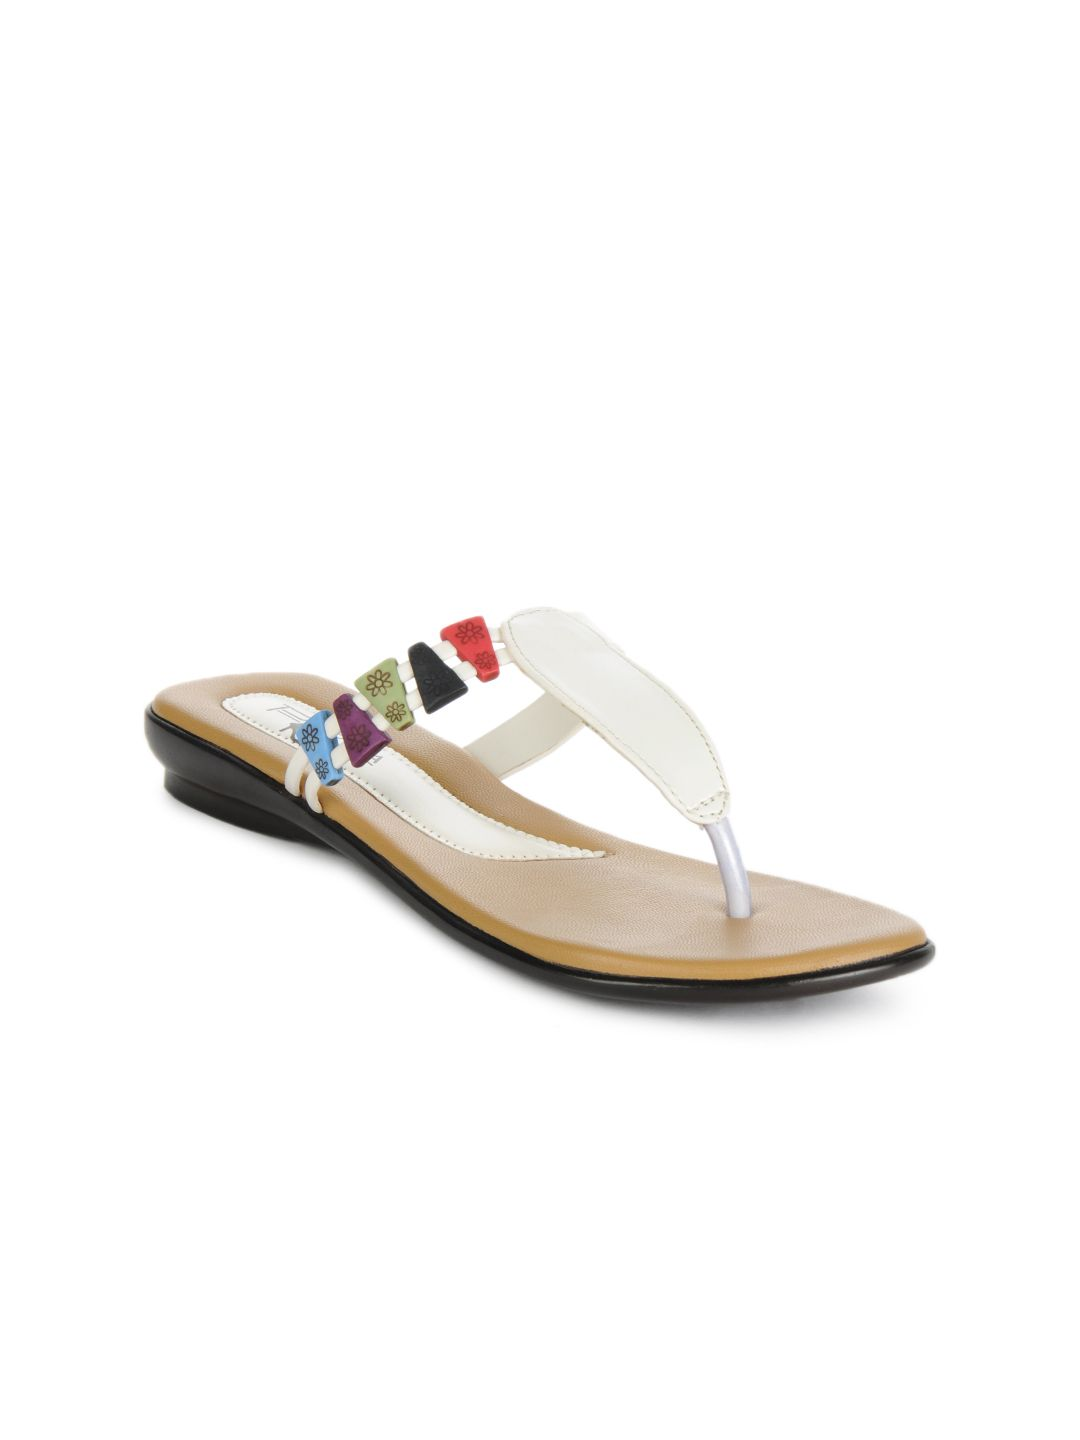

Product ID: 47625
Article Type: Heels
Similarity Score: N/A
Gender Match: Same Gender
------------------------------


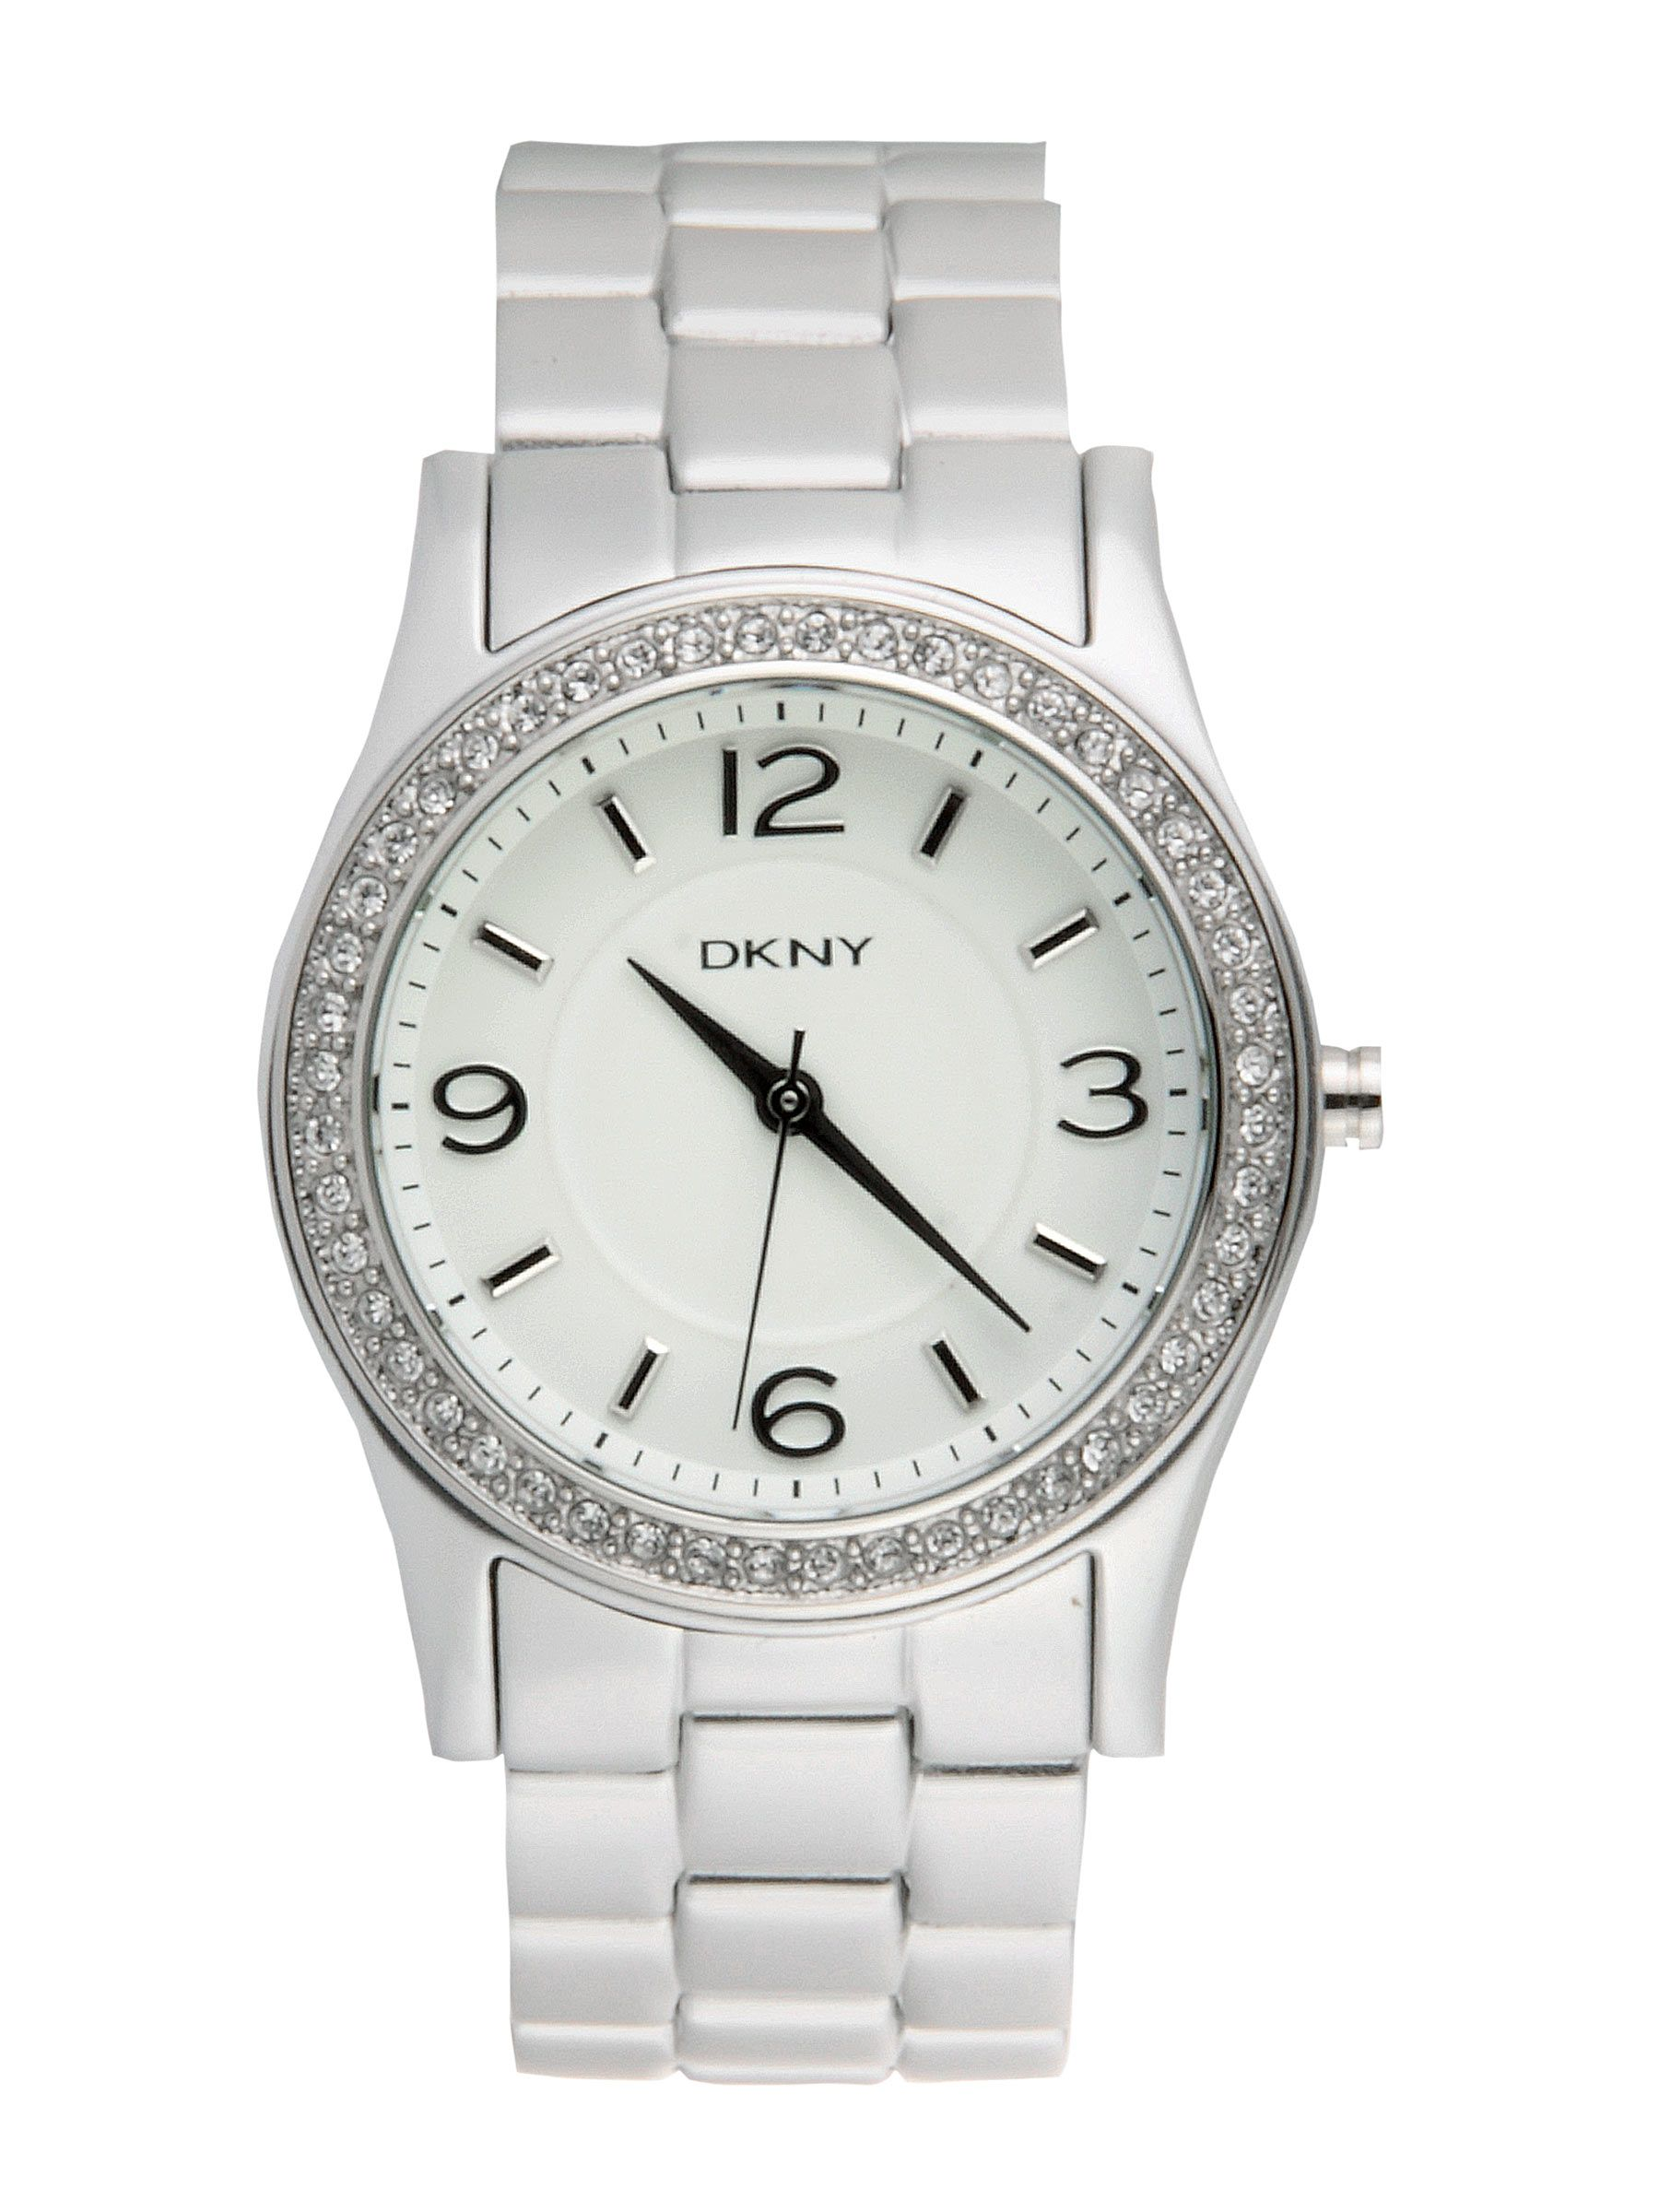

Product ID: 26344
Article Type: Watches
Similarity Score: N/A
Gender Match: Same Gender
------------------------------


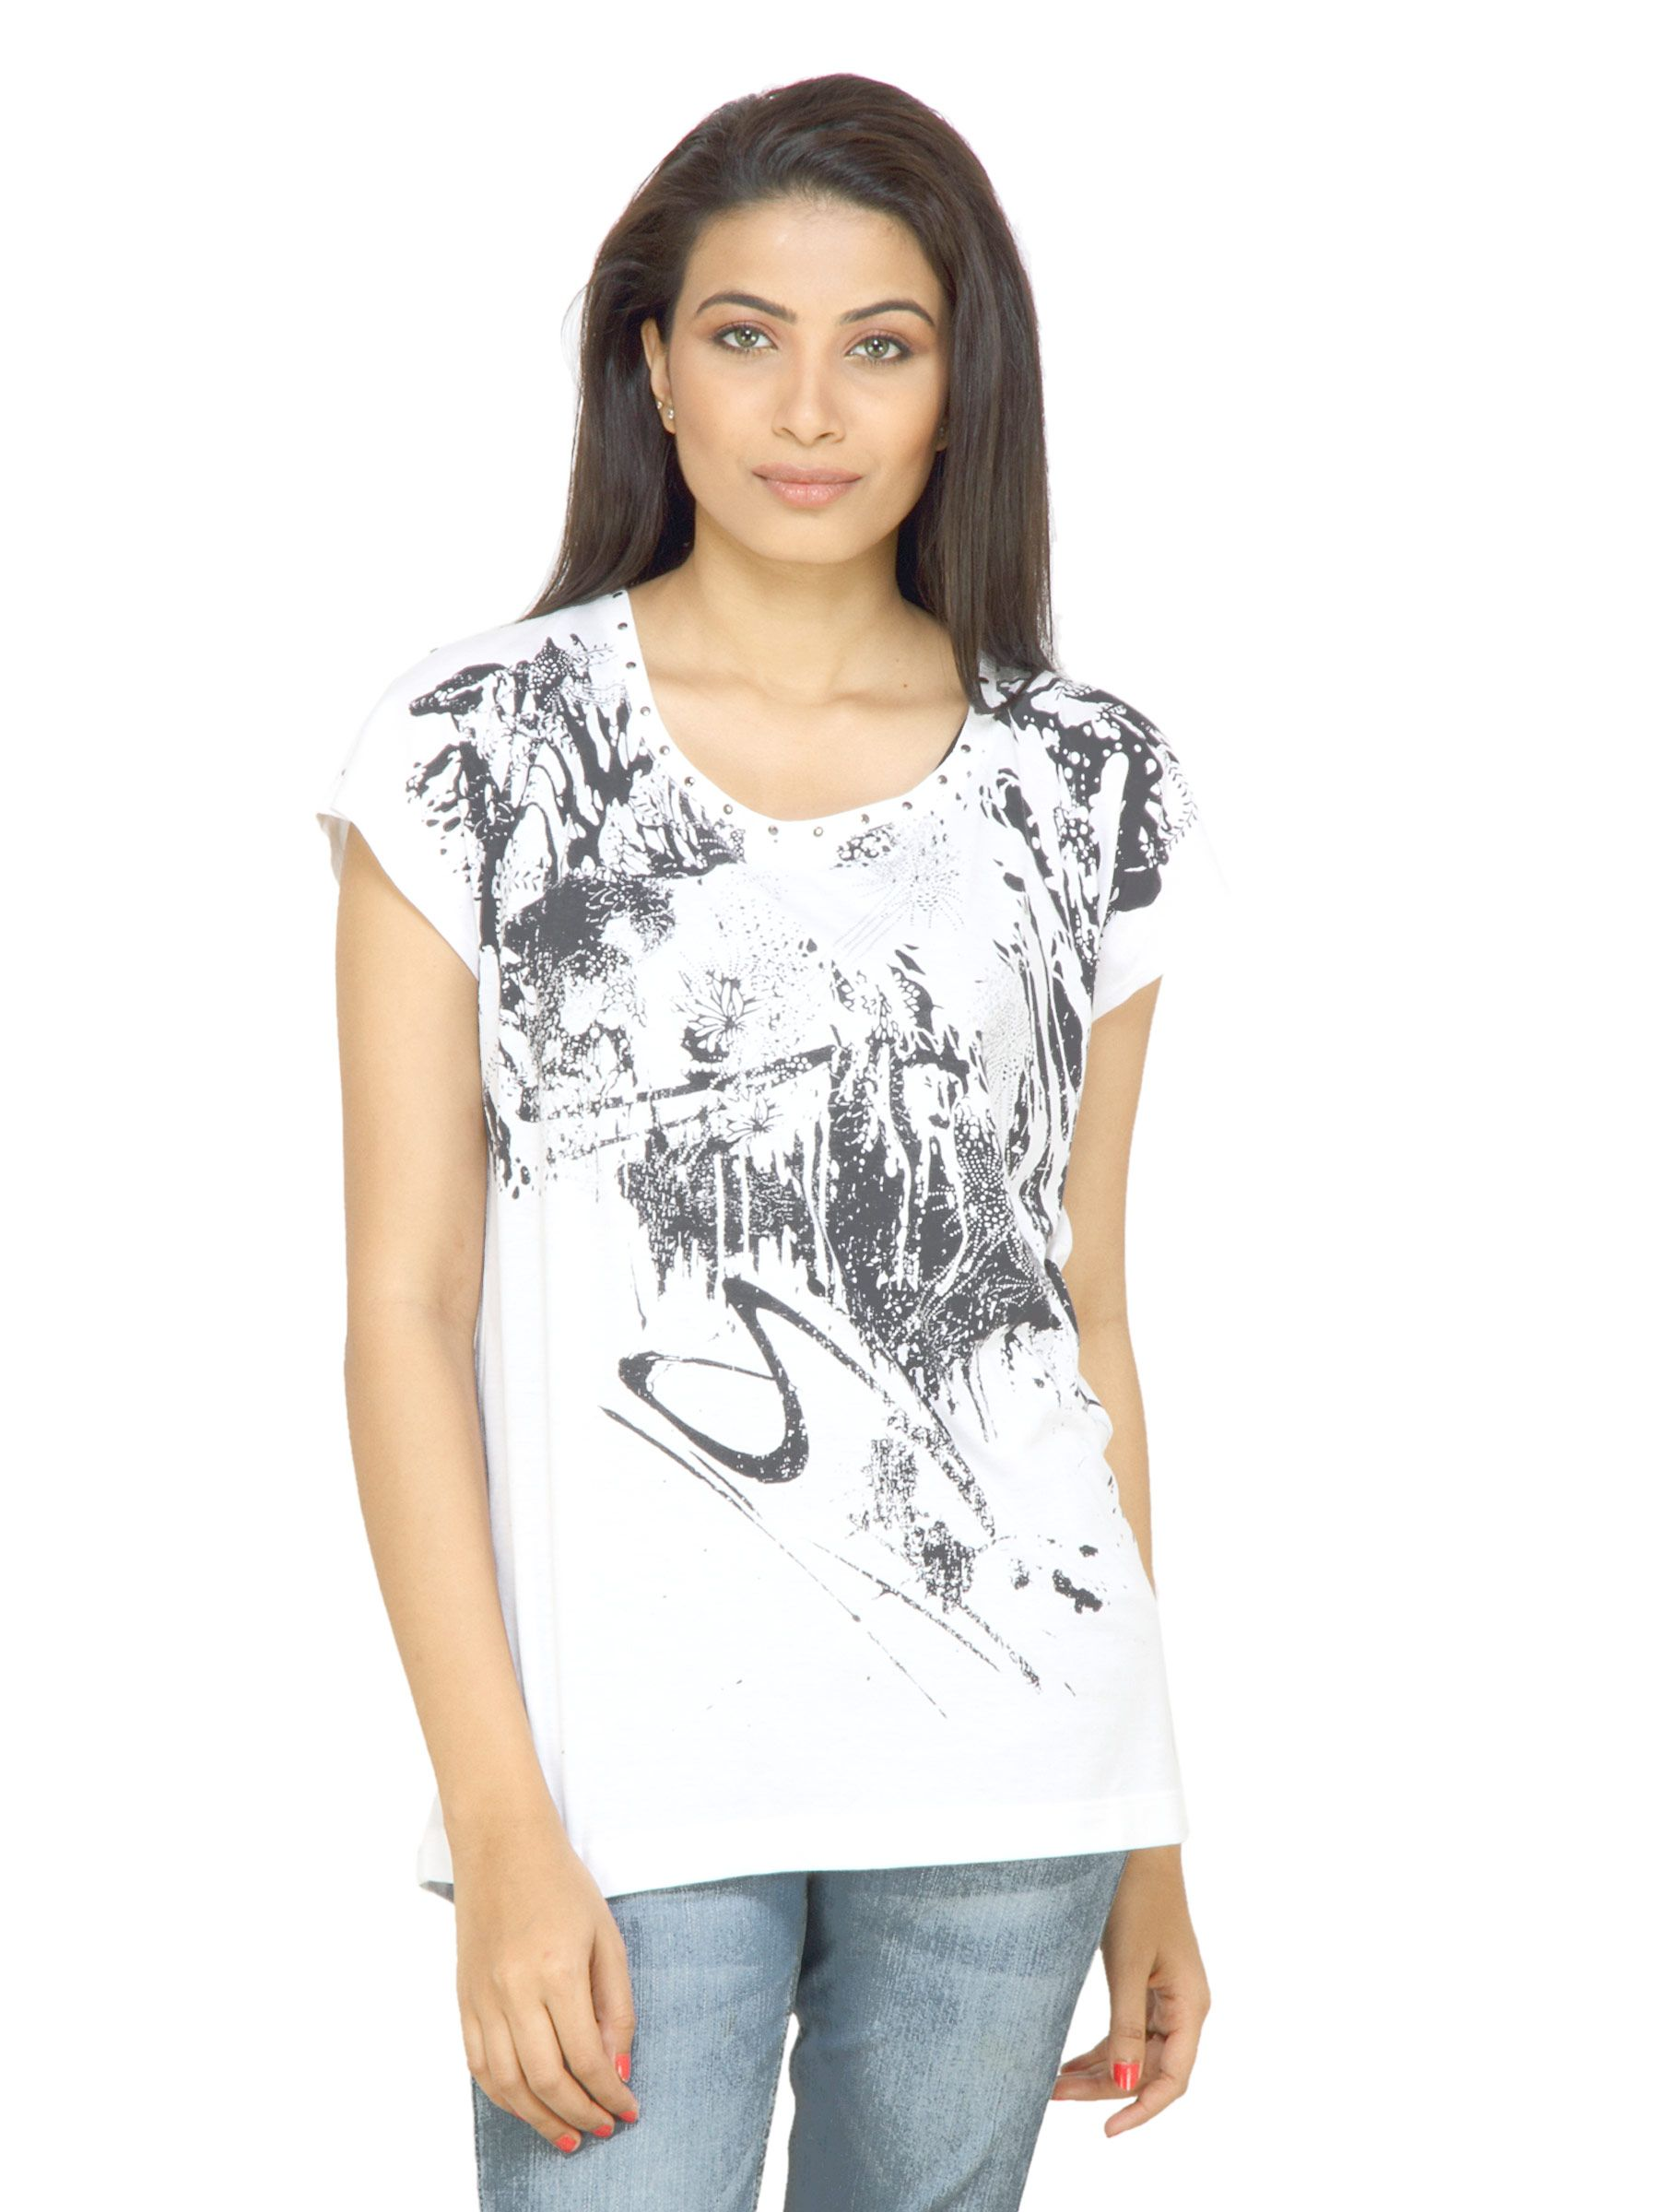

Product ID: 21160
Article Type: Tshirts
Similarity Score: N/A
Gender Match: Same Gender
------------------------------


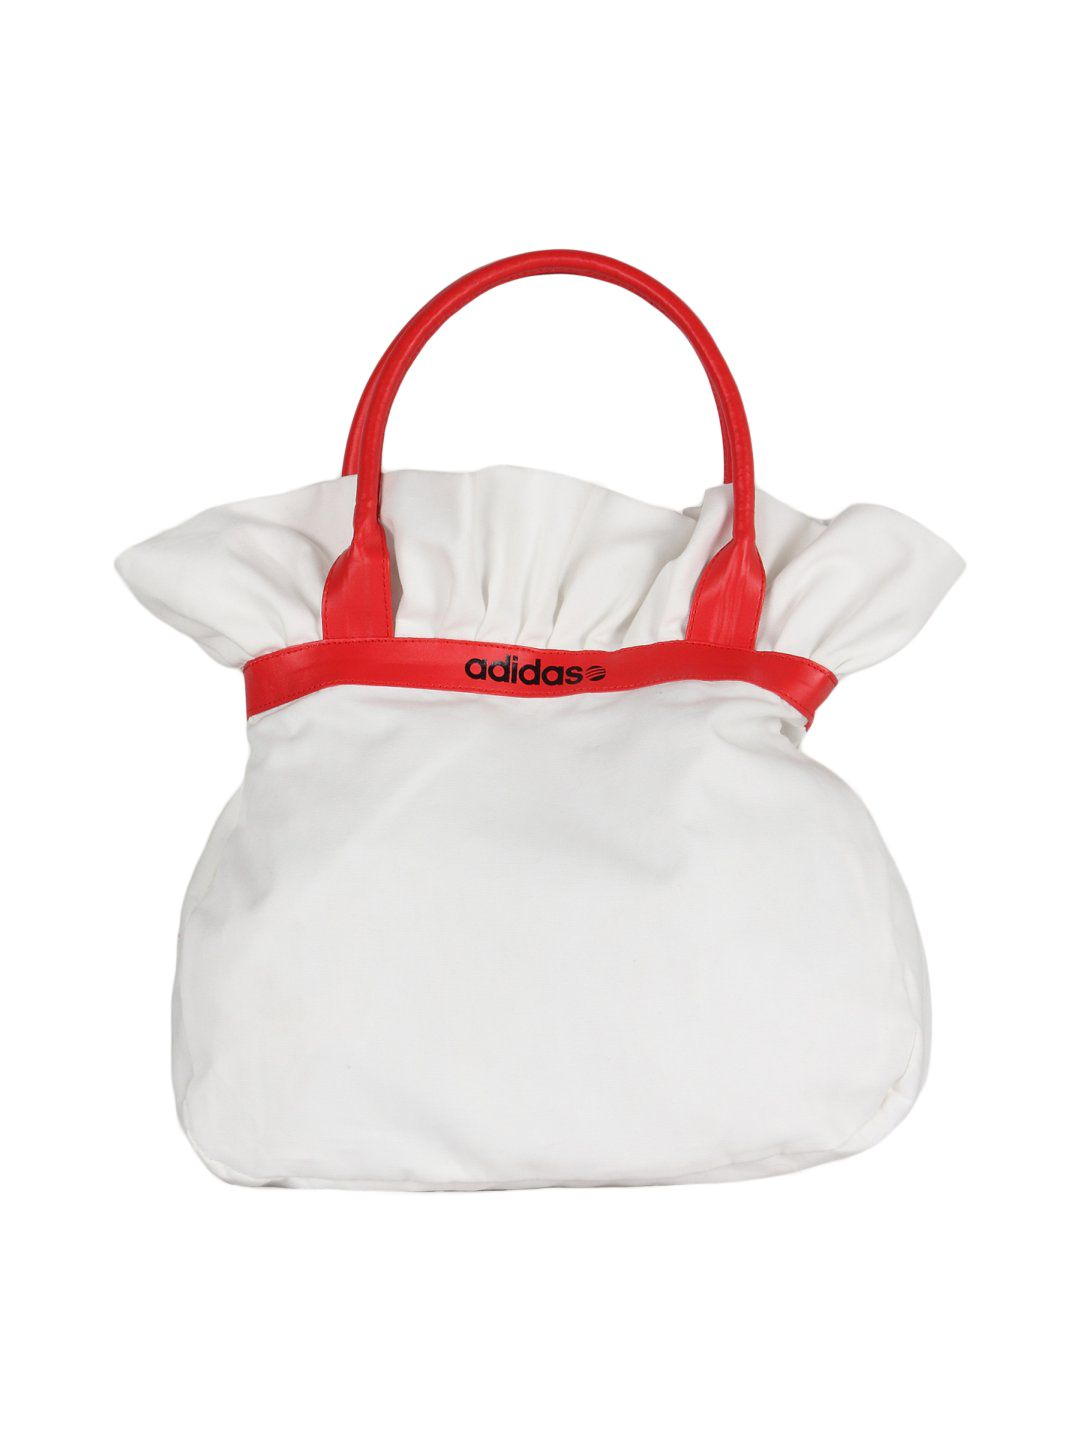

Product ID: 5855
Article Type: Handbags
Similarity Score: N/A
Gender Match: Same Gender
------------------------------


In [ ]:
import numpy as np
import pandas as pd
import cv2
from IPython.display import display, Image
import matplotlib.pyplot as plt

# Ensure filename column is generated if it doesn't exist
def add_filename_column(df):
    if 'filename' not in df.columns:
        df['filename'] = df['id'].astype(str) + ".jpg"  # Assuming filenames are based on 'id' with .jpg extension
    return df

# Display recommendations with images and details
def display_recommendations_with_images(recommended_items, image_folder_path):
    recommended_items = add_filename_column(recommended_items)  # Add filename if missing

    for idx, item in recommended_items.iterrows():
        # Get item details
        item_id = item['id']
        articleType = item['articleType']
        baseColour = item['baseColour']
        similarity_score = item.get('similarity', 'N/A')  # Optional if similarity score exists
        gender_match = "Same Gender" if item['gender'] == input_item_info['gender'] else "Different Gender"

        # Construct image path
        image_path = f"{image_folder_path}/{item['filename']}"

        # Display image inline with IPython
        try:
            display(Image(filename=image_path, width=150, height=150))
        except FileNotFoundError:
            print(f"Image for Product ID {item_id} not found.")

        # Print item details
        print(f"Product ID: {item_id}")
        print(f"Article Type: {articleType}")
        #print(f"Base Colour: {baseColour}")
        print(f"Similarity Score: {similarity_score}")
        print(f"Gender Match: {gender_match}")
        print("-" * 30)

# Sample usage
image_folder_path = '/content/drive/MyDrive/Images'  # Define your image folder path

# Ensure your `recommended_outfit` DataFrame is passed correctly
display_recommendations_with_images(recommended_outfit, image_folder_path)
